In [11]:
%matplotlib inline
%load_ext nb_black
import sys
from itertools import groupby
from pdb import set_trace

import pandas as pd
from scipy.optimize import minimize, brute, fmin
from random import random, randint, choice
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score


def array_softmax(Q, T):
    """Array based calculation of softmax probabilities for binary choices.
    Q: Action values - array([n_trials,2])
    T: Inverse temp  - float."""
    P = np.zeros(Q.shape)
    TdQ = -T * (Q[:, 0] - Q[:, 1])
    TdQ[
        TdQ > LOG_MAX_FLOAT
    ] = LOG_MAX_FLOAT  # Protection against overflow in exponential.
    P[:, 0] = 1.0 / (1.0 + np.exp(TdQ))
    P[:, 1] = 1.0 - P[:, 0]
    return P


def protected_log(x):
    "Return log of x protected against giving -inf for very small values of x."
    return np.log(((1e-200) / 2) + (1 - (1e-200)) * x)


def choose(P):
    "Takes vector of probabilities P summing to 1, returns integer s with prob P[s]"
    return sum(np.cumsum(P) < random())


def softmax(Q, T):
    "Softmax choice probs given values Q and inverse temp T."
    QT = Q * T
    QT[
        QT > LOG_MAX_FLOAT
    ] = LOG_MAX_FLOAT  # Protection against overflow in exponential.
    expQT = np.exp(QT)
    return expQT / expQT.sum()


def simulate(params, r_states, n_trials, rprob):

    p_r, p_lapse = params
    good_prob = 0.8

    p_1 = 0.5  # Probability world is in state 1.
    p_all = np.zeros(n_trials + 1)
    p_all[0] = p_1
    p_o_1 = np.array(
        [
            [
                good_prob,
                1 - good_prob,
            ],  # Probability of observed outcome given world in state 1.
            [1 - good_prob, good_prob],
        ]
    )  # Indicies:  p_o_1[second_step, outcome]

    p_o_0 = 1 - p_o_1  # Probability of observed outcome given world in state 0.

    choices, second_steps, outcomes = (
        np.zeros(n_trials, int),
        np.zeros(n_trials, int),
        np.zeros(n_trials, int),
    )

    for i in range(n_trials):

        # Generate trial events.
        c = s = int((p_1 > 0.5) == (random() > p_lapse))
        o = int(random() <= rprob) if c == r_states[i] else int(random() > rprob)

        # Bayesian update of state probabilties given observed outcome.
        p_1 = p_o_1[s, o] * p_1 / (p_o_1[s, o] * p_1 + p_o_0[s, o] * (1 - p_1))
        # Update of state probabilities due to possibility of block reversal.
        p_1 = (1 - p_r) * p_1 + p_r * (1 - p_1)
        p_all[i + 1] = p_1
        choices[i], second_steps[i], outcomes[i] = (c, s, o)

    return choices, second_steps, outcomes, p_all


def session_likelihood(params, return_q=False):

    # Unpack trial events.
    choices, second_steps, outcomes = (
        results["choices"].astype(int),
        results["second_steps"].astype(int),
        results["outcomes"].astype(int),
    )

    # Unpack parameters.
    p_r, p_lapse = params
    good_prob = 0.8

    p_o_1 = np.array(
        [
            [
                good_prob,
                1 - good_prob,
            ],  # Probability of observed outcome given world in state 1.
            [1 - good_prob, good_prob],
        ]
    )  # Indicies:  p_o_1[second_step, outcome]

    p_o_0 = 1 - p_o_1  # Probability of observed outcome given world in state 0.

    p_1 = np.zeros(n_trials + 1)  # Probability world is in state 1.
    p_1[0] = 0.5

    for i, (c, s, o) in enumerate(
        zip(choices, second_steps, outcomes)
    ):  # loop over trials.

        # Bayesian update of state probabilties given observed outcome.
        p_1[i + 1] = (
            p_o_1[s, o] * p_1[i] / (p_o_1[s, o] * p_1[i] + p_o_0[s, o] * (1 - p_1[i]))
        )
        # Update of state probabilities due to possibility of block reversal.
        p_1[i + 1] = (1 - p_r) * p_1[i + 1] + p_r * (1 - p_1[i + 1])

    # Evaluate choice probabilities and likelihood.
    choice_probs = np.zeros([n_trials + 1, 2])
    choice_probs[:, 1] = (p_1 > 0.5) * (1 - p_lapse) + (p_1 <= 0.5) * p_lapse
    choice_probs[:, 0] = 1 - choice_probs[:, 1]
    trial_log_likelihood = protected_log(choice_probs[np.arange(n_trials), choices])
    session_log_likelihood = np.sum(trial_log_likelihood)

    if return_q:
        return -session_log_likelihood, choice_probs
    else:
        return -session_log_likelihood


def before_after_chg_accuracy(results, choices_pred):
    results = results.assign(choices_pred=choices_pred)
    """where states change"""
    change_index = (
        (results.r_state != results.r_state.shift())
        .where(lambda x: x == True)
        .dropna()
        .index[1:]
    )

    """get 20 indices before and after change index"""
    buffer_length = 20
    before_after_chgs = pd.DataFrame(
        [
            [
                results.loc[i, "r_state"],
                results.loc[
                    i - buffer_length : i + buffer_length, ["choices", "choices_pred"]
                ]
                .apply(lambda x: x.values[0] == x.values[1], 1)
                .values.ravel(),
            ]
            for i in change_index
        ],
        columns=["to_state", "accuracy"],
    )

    before_after_chgs = before_after_chgs[
        before_after_chgs.accuracy.apply(len) == 1 + buffer_length * 2
    ]
    """plot"""
    plt.figure(figsize=(15, 3))
    plt.plot(np.vstack(before_after_chgs.accuracy).mean(0))
    plt.xticks(
        ticks=range(1 + buffer_length * 2),
        labels=np.arange(-buffer_length, buffer_length + 1),
    )
    plt.xlabel("before or after change points (0 is the start of the later state)")
    plt.ylabel("average accuracy")
    plt.title(label="before and after state transition accuracy")


def do_logistic_regression(L, rwds, actions, ax, method="rwd_choice"):
    if method == "rwd_choice":
        data = (
            pd.concat(
                [
                    pd.Series(rwds * actions).shift(i).rename("last" + str(i))
                    for i in range(1, L)
                ],
                1,
            )
            .assign(y=actions)
            .dropna()
        )
    if method == "rwd":
        data = (
            pd.concat(
                [pd.Series(rwds).shift(i).rename("last" + str(i)) for i in range(1, L)],
                1,
            )
            .assign(y=actions)
            .dropna()
        )
    if method == "choice":
        data = (
            pd.concat(
                [
                    pd.Series(actions).shift(i).rename("last" + str(i))
                    for i in range(1, L)
                ],
                1,
            )
            .assign(y=actions)
            .dropna()
        )

    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    model = LogisticRegression(class_weight="balanced")
    model.fit(X_train, y_train)

    pred = model.predict(X_test)
    print("accuracy:", accuracy_score(y_test, pred))
    pd.DataFrame(model.coef_, columns=X.columns).T.rename(columns={0: "weight"}).plot(
        ax=ax, marker="o"
    )


LOG_MAX_FLOAT = np.log(sys.float_info.max / 2.1)

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

trial length: 1277
current reward probability: 0.8
reward states and each block length:
     r_state  state_length
0       1.0            66
1       0.0            58
2       1.0            96
3       0.0            52
4       1.0            79
5       0.0            52
6       1.0            50
7       0.0            50
8       1.0            50
9       0.0            77
10      1.0            50
11      0.0            50
12      1.0            54
13      0.0            60
14      1.0            52
15      0.0            67
16      1.0            50
17      0.0            50
18      1.0            50
19      0.0            50
20      1.0            51
21      0.0            63
Optimization terminated successfully    (Exit mode 0)
            Current function value: 574.0951546759716
            Iterations: 1410
            Function evaluations: 18314
            Gradient evaluations: 1410
fitted: [0.00794711 0.16998064]
likelihood: 574.0951546759716
prediction accuracy: 0.693030540328

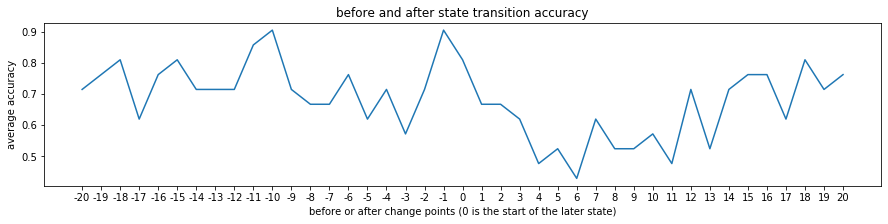

<IPython.core.display.Javascript object>

In [3]:
"""read data"""
df = pd.read_csv("xieyang_behaviordata.csv").rename(
    columns={"c_cue": "choices", "rwd_fed": "outcomes"}
)
df = df.assign(second_steps=df.choices)
results = df[df.file == "M150241_session6_bhv_ana.mat"].replace(-1, 0)
n_trials = results.shape[0]

print("trial length:", n_trials)
print("current reward probability:", results.rprob.unique()[0])
print(
    "reward states and each block length:\n",
    pd.DataFrame(
        [[idx, len(list(item))] for idx, item in groupby(results.r_state)],
        columns=["r_state", "state_length"],
    ),
)

"""fit the parameters"""
initial = brute(
    session_likelihood,
    ranges=(slice(0, 1, 0.1), slice(0, 1, 0.1)),
    finish=fmin,
    workers=-1,
)
res = minimize(
    session_likelihood,
    x0=initial,
    method="SLSQP",
    bounds=[(0, 1), (0, 1)],
    options={"eps": 0.1, "disp": True, "ftol": 1e-10, "maxiter": 10000},
)
print("fitted:", res.x)

"""check likelihood and Q"""
likelihood, choice_probability = session_likelihood(res.x, True)
print("likelihood:", likelihood)

# plt.figure(figsize=(15, 3))
# plt.plot(Q[:200])
# plt.title("First 200 Q changes")

"""predict choice using fitted parameters"""
(choices_pred, second_steps_pred, outcomes_pred, p_pred) = simulate(
    res.x, results.r_state.values, n_trials, results.rprob.values[0]
)

print("prediction accuracy:", (choices_pred == results.choices).mean())

before_after_chg_accuracy(results, choices_pred)

Text(0, 0.5, 'probability')

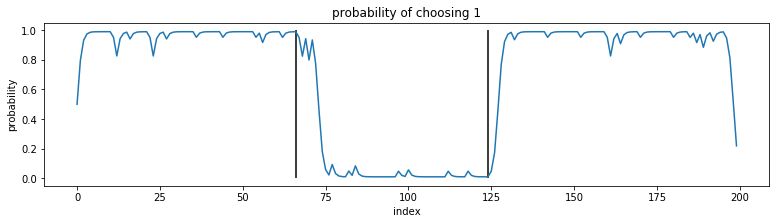

<IPython.core.display.Javascript object>

In [5]:
cutoffs = (
    pd.DataFrame(
        [[idx, len(list(item))] for idx, item in groupby(results.r_state)],
        columns=["r_state", "state_length"],
    )
    .state_length.cumsum()
    .values
)
plt.figure(figsize=(13, 3))
plt.plot(p_pred[:200])
plt.vlines(x=cutoffs[cutoffs <= 200], ymin=0, ymax=1)
plt.title("probability of choosing 1")
plt.xlabel("index")
plt.ylabel("probability")

#### Logistic Regression

accuracy: 0.7769028871391076
accuracy: 0.4645669291338583
accuracy: 0.7926509186351706


/home/tyang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/tyang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/tyang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


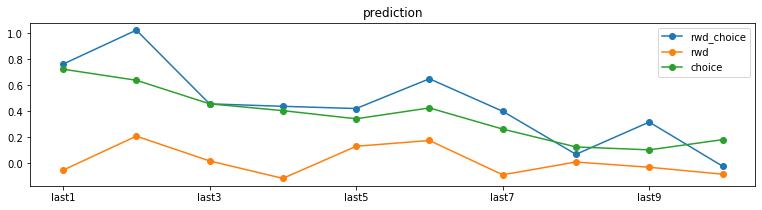

<IPython.core.display.Javascript object>

In [14]:
fig, ax = plt.subplots(figsize=(13, 3))
ax.set_title("prediction")
for i in ["rwd_choice", "rwd", "choice"]:
    do_logistic_regression(11, outcomes_pred, choices_pred, ax, i)
plt.legend(["rwd_choice", "rwd", "choice"])

fig, ax = plt.subplots(figsize=(13, 3))
ax.set_title("actual")
for i in ["rwd_choice", "rwd", "choice"]:
    do_logistic_regression(11, results.outcomes.values, results.choices.values, ax, i)
plt.legend(["rwd_choice", "rwd", "choice"])